In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
df1 = pd.read_csv('../../../_data/Sepulveda_et_al_2020-master/data/perceptual/GlamDataPF2019_Less_NoBin.csv', index_col=0)
df2 = pd.read_csv('../../../_data/Sepulveda_et_al_2020-master/data/perceptual/GlamDataPF2019_More_NoBin.csv', index_col=0)
df1['goal'] = -1
df2['goal'] = 1
data_df = pd.concat([df1, df2]).sort_values(by=['subject', 'trial'])
data_df.reset_index(drop=True, inplace=True)

data_df['rt'] /= 1000

data_df.rename(columns={'subject': 'sbj'}, inplace=True)
data_df['sbj'] = data_df['sbj'].map({data_df['sbj'].unique()[i]:i+1 for i in range(len(data_df['sbj'].unique()))})

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 3 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df.reset_index(drop=True, inplace=True)

data_df['value diff'] = data_df['item_value_1'] - data_df['item_value_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['value diff'] = kbins.fit_transform(data_df[['value diff']])
mms = MinMaxScaler(feature_range=(-20, 20))
data_df['Right Value - Left Value'] = mms.fit_transform(data_df[['value diff']])

data_df['gaze diff'] = data_df['gaze_1'] - data_df['gaze_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - L)'] = mms.fit_transform(data_df[['gaze diff']])

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'choice']])
X_train = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

obs_test = np.asarray(data_df[['rt', 'choice']])
X_test = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

print(X_train.shape, X_test.shape)

(7555, 5) (7555, 5)


In [5]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)

In [6]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [7]:
layers_neuron = [10, 10, 10, 8]
input_shape = 5
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 8)                 88        
                                                                 
 out_layer (Out_layer)       (None, 2)                 114       
                                                                 
Total params: 482 (1.88 KB)
Trainable params: 482 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [28]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3500)

Epoch 1/500
1/1 [==============================] - 0s 157ms/step - loss: 33102.1094
Epoch 2/500
1/1 [==============================] - 0s 71ms/step - loss: 33102.3320
Epoch 3/500
1/1 [==============================] - 0s 67ms/step - loss: 33096.9766
Epoch 4/500
1/1 [==============================] - 0s 68ms/step - loss: 33098.6094
Epoch 5/500
1/1 [==============================] - 0s 68ms/step - loss: 33095.2109
Epoch 6/500
1/1 [==============================] - 0s 67ms/step - loss: 33097.6094
Epoch 7/500
1/1 [==============================] - 0s 72ms/step - loss: 33094.0234
Epoch 8/500
1/1 [==============================] - 0s 67ms/step - loss: 33097.1523
Epoch 9/500
1/1 [==============================] - 0s 68ms/step - loss: 33095.8359
Epoch 10/500
1/1 [==============================] - 0s 66ms/step - loss: 33098.1406
Epoch 11/500
1/1 [==============================] - 0s 67ms/step - loss: 33094.5820
Epoch 12/500
1/1 [==============================] - 0s 67ms/step - loss: 33095.8125


1/1 [==============================] - 0s 67ms/step - loss: 33008.4102
Epoch 99/500
1/1 [==============================] - 0s 67ms/step - loss: 33004.5078
Epoch 100/500
1/1 [==============================] - 0s 65ms/step - loss: 33006.9453
Epoch 101/500
1/1 [==============================] - 0s 64ms/step - loss: 33006.0469
Epoch 102/500
1/1 [==============================] - 0s 65ms/step - loss: 33006.7656
Epoch 103/500
1/1 [==============================] - 0s 67ms/step - loss: 33001.1133
Epoch 104/500
1/1 [==============================] - 0s 66ms/step - loss: 33002.2188
Epoch 105/500
1/1 [==============================] - 0s 68ms/step - loss: 32998.2344
Epoch 106/500
1/1 [==============================] - 0s 68ms/step - loss: 32999.2266
Epoch 107/500
1/1 [==============================] - 0s 67ms/step - loss: 32996.4570
Epoch 108/500
1/1 [==============================] - 0s 66ms/step - loss: 32998.2188
Epoch 109/500
1/1 [==============================] - 0s 64ms/step - loss: 32994.

1/1 [==============================] - 0s 65ms/step - loss: 32917.3984
Epoch 195/500
1/1 [==============================] - 0s 65ms/step - loss: 32914.8516
Epoch 196/500
1/1 [==============================] - 0s 67ms/step - loss: 32916.3359
Epoch 197/500
1/1 [==============================] - 0s 66ms/step - loss: 32913.8516
Epoch 198/500
1/1 [==============================] - 0s 66ms/step - loss: 32914.1172
Epoch 199/500
1/1 [==============================] - 0s 66ms/step - loss: 32909.7188
Epoch 200/500
1/1 [==============================] - 0s 67ms/step - loss: 32911.3438
Epoch 201/500
1/1 [==============================] - 0s 65ms/step - loss: 32908.1914
Epoch 202/500
1/1 [==============================] - 0s 67ms/step - loss: 32910.4062
Epoch 203/500
1/1 [==============================] - 0s 67ms/step - loss: 32909.2422
Epoch 204/500
1/1 [==============================] - 0s 68ms/step - loss: 32911.9727
Epoch 205/500
1/1 [==============================] - 0s 68ms/step - loss: 32909

1/1 [==============================] - 0s 71ms/step - loss: 32830.4180
Epoch 291/500
1/1 [==============================] - 0s 68ms/step - loss: 32826.7734
Epoch 292/500
1/1 [==============================] - 0s 66ms/step - loss: 32828.3945
Epoch 293/500
1/1 [==============================] - 0s 72ms/step - loss: 32826.2930
Epoch 294/500
1/1 [==============================] - 0s 70ms/step - loss: 32828.1758
Epoch 295/500
1/1 [==============================] - 0s 69ms/step - loss: 32825.6680
Epoch 296/500
1/1 [==============================] - 0s 68ms/step - loss: 32826.9531
Epoch 297/500
1/1 [==============================] - 0s 66ms/step - loss: 32822.4766
Epoch 298/500
1/1 [==============================] - 0s 67ms/step - loss: 32823.2070
Epoch 299/500
1/1 [==============================] - 0s 69ms/step - loss: 32819.1523
Epoch 300/500
1/1 [==============================] - 0s 67ms/step - loss: 32820.5391
Epoch 301/500
1/1 [==============================] - 0s 66ms/step - loss: 32818

1/1 [==============================] - 0s 67ms/step - loss: 32751.3711
Epoch 387/500
1/1 [==============================] - 0s 68ms/step - loss: 32746.9922
Epoch 388/500
1/1 [==============================] - 0s 68ms/step - loss: 32748.0254
Epoch 389/500
1/1 [==============================] - 0s 66ms/step - loss: 32743.3867
Epoch 390/500
1/1 [==============================] - 0s 67ms/step - loss: 32744.2773
Epoch 391/500
1/1 [==============================] - 0s 65ms/step - loss: 32741.5859
Epoch 392/500
1/1 [==============================] - 0s 66ms/step - loss: 32744.1328
Epoch 393/500
1/1 [==============================] - 0s 65ms/step - loss: 32742.7148
Epoch 394/500
1/1 [==============================] - 0s 67ms/step - loss: 32745.4414
Epoch 395/500
1/1 [==============================] - 0s 68ms/step - loss: 32742.9648
Epoch 396/500
1/1 [==============================] - 0s 65ms/step - loss: 32744.6367
Epoch 397/500
1/1 [==============================] - 0s 70ms/step - loss: 32742

1/1 [==============================] - 0s 69ms/step - loss: 32687.4141
Epoch 483/500
1/1 [==============================] - 0s 68ms/step - loss: 32685.7227
Epoch 484/500
1/1 [==============================] - 0s 66ms/step - loss: 32686.8672
Epoch 485/500
1/1 [==============================] - 0s 66ms/step - loss: 32684.9961
Epoch 486/500
1/1 [==============================] - 0s 67ms/step - loss: 32684.1504
Epoch 487/500
1/1 [==============================] - 0s 72ms/step - loss: 32678.7891
Epoch 488/500
1/1 [==============================] - 0s 67ms/step - loss: 32677.7031
Epoch 489/500
1/1 [==============================] - 0s 66ms/step - loss: 32674.8281
Epoch 490/500
1/1 [==============================] - 0s 66ms/step - loss: 32676.2559
Epoch 491/500
1/1 [==============================] - 0s 66ms/step - loss: 32673.5859
Epoch 492/500
1/1 [==============================] - 0s 68ms/step - loss: 32675.6367
Epoch 493/500
1/1 [==============================] - 0s 68ms/step - loss: 32674

In [29]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

237/237 [==============================] - 0s 385us/step


In [30]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'goal':[],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['goal'].append(ts_df.goal[s])
        pred_bhv['value_diff'].append(ts_df['Right Value - Left Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

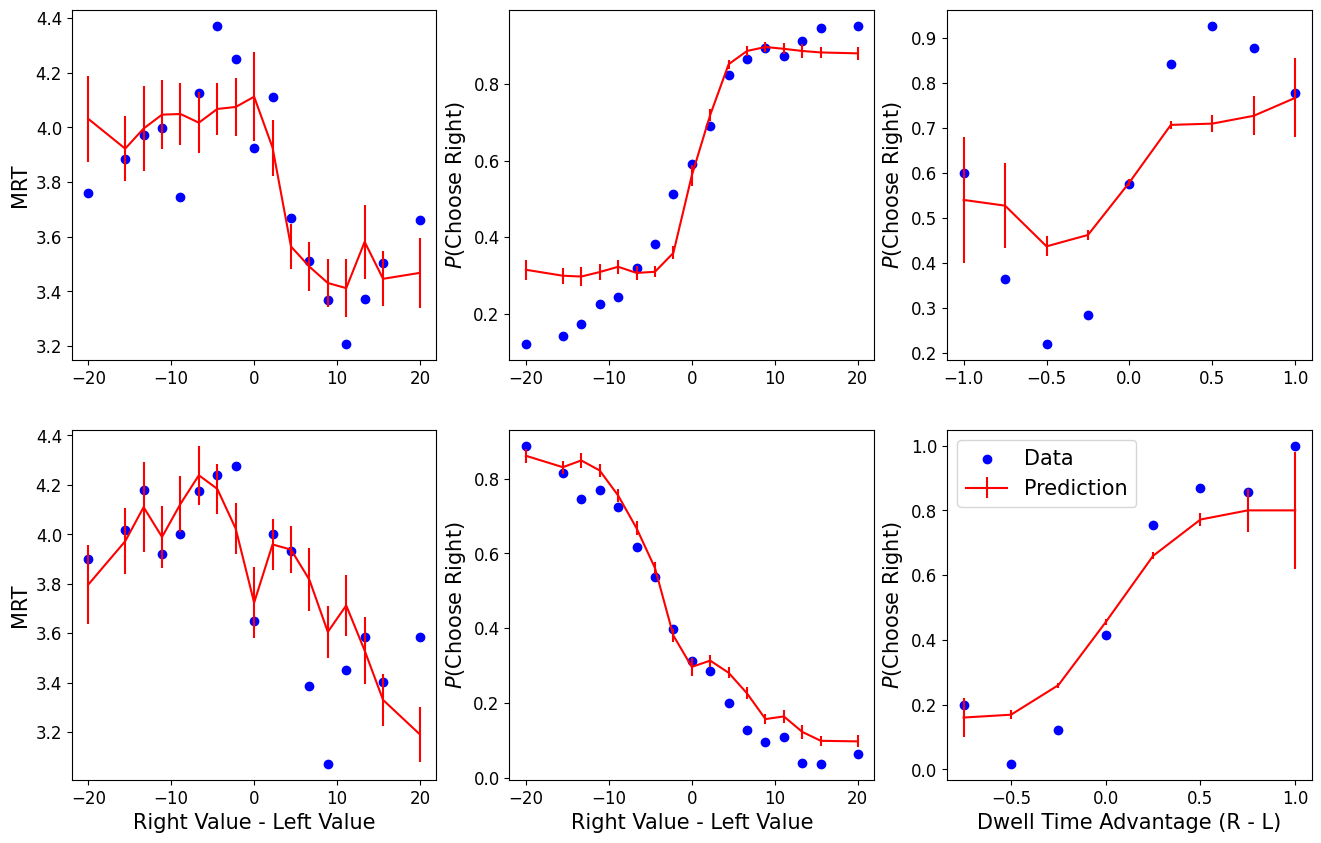

In [36]:
plt.figure(figsize=(16, 10))
plt.subplot(231)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.ylabel('MRT');

plt.subplot(232)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(233)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), c='blue');
plt.ylabel(r'$P$(Choose Right)');

###########
plt.subplot(234)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel('MRT');

plt.subplot(235)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(236)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, label='Prediction', c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), c='blue', label='Data');
plt.xlabel('Dwell Time Advantage (R - L)');
plt.ylabel(r'$P$(Choose Right)');
plt.legend();

plt.savefig('_plots/sp2020_perceptual_complete_postpred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');

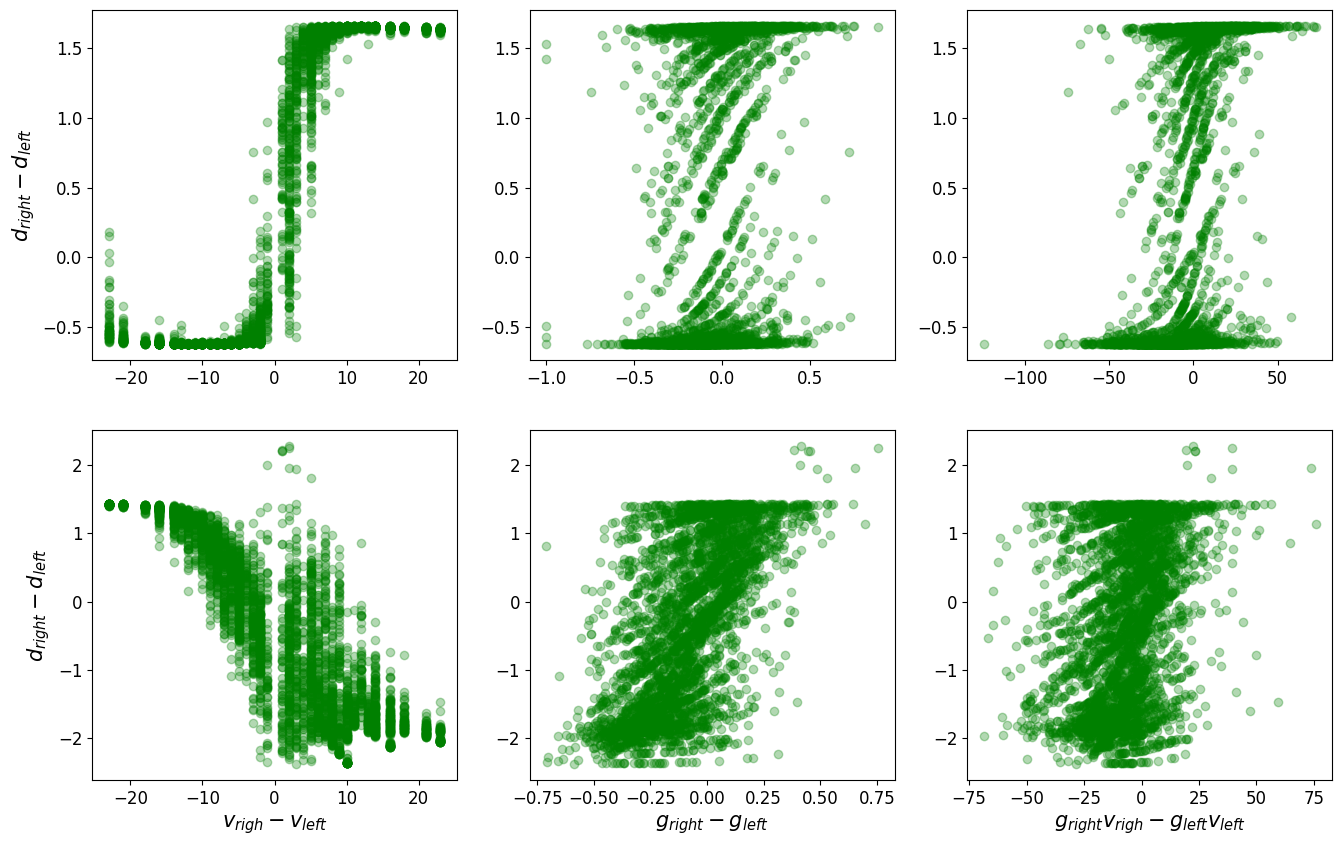

In [37]:
plt.figure(figsize=(16, 10))
plt.subplot(231)
plt.scatter(X_test[X_test[:, -1]==1, 1] - X_test[X_test[:, -1]==1, 0], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(232)
plt.scatter(X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');


plt.subplot(233)
plt.scatter(X_test[X_test[:, -1]==1, 1]*X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 0]*X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');

#####################
plt.subplot(234)
plt.scatter(X_test[X_test[:, -1]==-1, 1] - X_test[X_test[:, -1]==-1, 0], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$v_{righ} - v_{left}$ ');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(235)
plt.scatter(X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(236)
plt.scatter(X_test[X_test[:, -1]==-1, 1]*X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 0]*X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

plt.savefig('_plots/sp2020_perceptual_complete_prmspred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');